<a href="https://colab.research.google.com/github/doodger/dataScience/blob/master/finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Under construction
This project seeks to compare historical American demographic trends and S&P 500 trends

In [0]:
#General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [93]:
#Data imports
populationURL = "https://raw.githubusercontent.com/doodger/dataScience/master/38f6e261-94a4-4bdf-b5db-5d75022e46bb_Data.csv"
SaP500URL = "https://raw.githubusercontent.com/doodger/dataScience/master/%5EGSPC.csv"

pop_df = pd.read_csv(populationURL)
sap_df = pd.read_csv(SaP500URL)

##Data cleaning and sorting for the population

#Demographics data
pop_df.head()
#Rows 35,36 and 37 are rows of Nan
#Rows 38 and 39 only have a value at the head, detailling the database's World bank origin

print("Total missing value for rows 0 to 34:",pop_df.loc[0:34].isnull().sum().sum())
pop_df = pop_df.loc[0:34]

#With the un-needed rows cut off, the dataframe can be reordered so that the rows of population groups
#    are in chronological order
pop_df = pop_df.sort_values("Series Code")
#Row 21 is superfluous (65+ women), and can be deleted. The index are then labeled to a proper order
pop_df = pop_df.drop([21])
pop_df.index= [i for i in range(34)]
#The 17 age groups are now in ascending order for both women and men

Total missing value for rows 0 to 34: 0


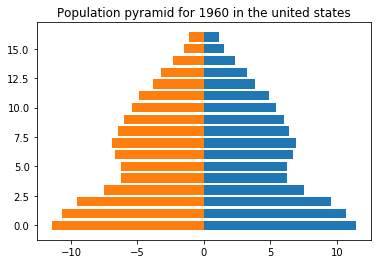

In [94]:
##Visualization
pop_df.loc[i,"1960 [YR1960]"]
#Sample age pyramid for 1960
yMen = [pop_df.loc[i,"1960 [YR1960]"] for i in range(1,34,2)]
yWomen = [-pop_df.loc[i,"1960 [YR1960]"] for i in range(1,34,2)]
#Here the women's number will be in the negative by convention


x = [i for i in range(17)]
print(ax.get_ylabel())
ax = plt.subplot(111)
ax.barh(x,yMen)
ax.barh(x,yWomen)
ax.set_title("Population pyramid for 1960 in the united states")
plt.show()


Total missing value for S&P data: 0


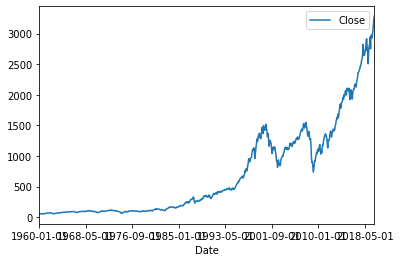

In [102]:
#Financial data
sap_df.head()
print("Total missing value for S&P data:",sap_df.isnull().sum().sum())

sap_df.plot.line(x="Date",y="Close")

## Exploratory data analysis
Ideas:

*  Volume?
*  Price increase?



In [101]:
sap_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1960-01-01,59.910000,60.389999,55.610001,55.610001,55.610001,63920000
1,1960-02-01,55.959999,56.820000,54.730000,56.119999,56.119999,60500000
2,1960-03-01,56.009998,56.009998,53.470001,55.340000,55.340000,65710000
3,1960-04-01,55.430000,56.590000,54.369999,54.369999,54.369999,57300000
4,1960-05-01,54.130001,55.830002,54.130001,55.830002,55.830002,68790000
...,...,...,...,...,...,...,...
716,2019-09-01,2909.010010,3021.989990,2891.850098,2976.739990,2976.739990,73992330000
717,2019-10-01,2983.689941,3050.100098,2855.939941,3037.560059,3037.560059,77564550000
718,2019-11-01,3050.719971,3154.260010,3050.719971,3140.979980,3140.979980,72179920000
719,2019-12-01,3143.850098,3247.929932,3070.330078,3230.780029,3230.780029,72054000000


TODO


*   Time series of S&P data
*   reoorder demographics data
*   dropping a row only once? pop_df[21]
*   cleaning the name of the rows and columns?
*   better age pyramid (inverse y axis, positive label instead of negative for women)

